# Rule-Based Baseline – Why Static Rules Fail

This notebook evaluates simple rule-based fraud detection baselines
to demonstrate their limitations from a **business and operational perspective**.

> The goal is not to build a strong detector,  
> but to quantify **why static rules fail at scale** and motivate a data-driven approach.


In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

# Load dataset
candidate_paths = ["data/creditcard.csv", "creditcard.csv"]
data_path = next((p for p in candidate_paths if os.path.exists(p)), None)

if data_path is None:
    raise FileNotFoundError("creditcard.csv not found. Put it in repo root or ./data/creditcard.csv")

df = pd.read_csv(data_path)
print("Loaded:", data_path)
df.shape


Loaded: data/creditcard.csv


(284807, 31)

## Why Start with Rules?

Rule-based systems are widely used in fraud detection because they are:
- easy to implement,
- easy to explain,
- fast to execute.

They often serve as:
- an initial fraud filter,
- a compliance safeguard,
- or a fallback mechanism in production systems.

However, static rules rely on **fixed thresholds**, which makes them fragile
in high-volume and evolving fraud environments.


In [10]:
target_col = "Class"

counts = df[target_col].value_counts().sort_index()
total = counts.sum()
fraud_rate = counts.get(1, 0) / total

print("Non-fraud:", counts.get(0, 0))
print("Fraud:", counts.get(1, 0))
print(f"Fraud rate: {fraud_rate:.4%}")


Non-fraud: 284315
Fraud: 492
Fraud rate: 0.1727%


## Baseline Rule Definition

We start with a simple and commonly used rule:

> **Flag a transaction as fraud if the transaction amount exceeds a fixed threshold.**

This type of rule is frequently used as:
- a first-line fraud control,
- a quick mitigation during fraud spikes,
- or a temporary rule while more advanced models are built.


In [11]:
AMOUNT_THRESHOLD = 200.0

df["rule_high_amount"] = (df["Amount"] > AMOUNT_THRESHOLD).astype(int)

df[["Amount", "Class", "rule_high_amount"]].head()


,Amount,Class,rule_high_amount
0,149.62,0,0
1,2.69,0,0
2,378.66,0,1
3,123.50,0,0
4,69.99,0,0


In [12]:
def eval_rule(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0.0

    # Operationally meaningful metric
    review_rate = (tp + fp) / len(y_true)

    return {
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "tp": tp,
        "recall": recall,
        "precision": precision,
        "false_positive_rate": false_positive_rate,
        "review_rate": review_rate
    }

metrics_r1 = eval_rule(df["Class"], df["rule_high_amount"])
metrics_r1


{'tn': np.int64(255563),
 'fp': np.int64(28752),
 'fn': np.int64(407),
 'tp': np.int64(85),
 'recall': np.float64(0.17276422764227642),
 'precision': np.float64(0.002947602039047058),
 'false_positive_rate': np.float64(0.10112727080878603),
 'review_rate': np.float64(0.10125102262233723)}

## Business Interpretation of Rule Performance

- **Recall** measures how much fraud is caught (missed fraud = direct financial loss).
- **False positive rate** reflects how many legitimate transactions are incorrectly blocked
  (customer friction and lost revenue).
- **Review rate** approximates operational load and manual review capacity.

Static amount thresholds force the business into a harsh trade-off:
increasing fraud recall usually comes at the cost of customer experience and operations.


In [13]:
thresholds = [25, 50, 75, 100, 150, 200, 300, 500, 1000]
rows = []

y_true = df["Class"]

for t in thresholds:
    y_pred = (df["Amount"] > t).astype(int)
    m = eval_rule(y_true, y_pred)

    rows.append({
        "threshold": t,
        "recall": m["recall"],
        "precision": m["precision"],
        "false_positive_rate": m["false_positive_rate"],
        "review_rate": m["review_rate"]
    })

sweep_df = pd.DataFrame(rows)
sweep_df


,threshold,recall,precision,false_positive_rate,review_rate
0,25,0.439024,0.001607,0.472142,0.472085
1,50,0.378049,0.001984,0.329128,0.329212
2,75,0.357724,0.002421,0.255041,0.255218
3,100,0.264228,0.002301,0.198294,0.198408
4,150,0.201220,0.002512,0.138290,0.138399
5,200,0.172764,0.002948,0.101127,0.101251
6,300,0.128049,0.003488,0.063303,0.063415
7,500,0.071138,0.003828,0.032031,0.032099
8,1000,0.018293,0.003061,0.010309,0.010323


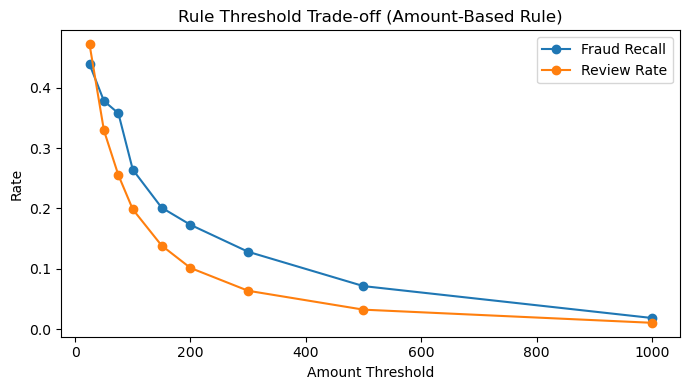

In [14]:
plt.figure(figsize=(7, 4))
plt.plot(sweep_df["threshold"], sweep_df["recall"], marker="o", label="Fraud Recall")
plt.plot(sweep_df["threshold"], sweep_df["review_rate"], marker="o", label="Review Rate")
plt.title("Rule Threshold Trade-off (Amount-Based Rule)")
plt.xlabel("Amount Threshold")
plt.ylabel("Rate")
plt.legend()
plt.tight_layout()
plt.show()


## Why This Fails in Production

This trade-off illustrates a core limitation of static rules:

- The business is forced to *choose* between fraud loss and customer friction.
- Small threshold changes can create disproportionate operational impact.
- Rule tuning becomes reactive, manual, and brittle over time.

This behavior does not scale with transaction volume or evolving fraud patterns.


In [15]:
COST_MISSED_FRAUD = 500    # cost per false negative
COST_FALSE_POSITIVE = 10  # cost per false positive

cost_rows = []

for t in thresholds:
    y_pred = (df["Amount"] > t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    total_cost = fn * COST_MISSED_FRAUD + fp * COST_FALSE_POSITIVE

    cost_rows.append({
        "threshold": t,
        "false_negatives": fn,
        "false_positives": fp,
        "estimated_total_cost": total_cost
    })

cost_df = pd.DataFrame(cost_rows).sort_values("estimated_total_cost")
cost_df


,threshold,false_negatives,false_positives,estimated_total_cost
8,1000,483,2931,270810
7,500,457,9107,319570
6,300,429,17998,394480
5,200,407,28752,491020
4,150,393,39318,589680
3,100,362,56378,744780
2,75,316,72512,883120
1,50,306,93576,1088760
0,25,276,134237,1480370


## Key Takeaways

- Rule-based systems are simple, interpretable, and useful as a first layer.
- Static thresholds create an unavoidable trade-off between:
  fraud prevention, customer experience, and operational cost.
- As transaction volume grows, rule tuning becomes unstable and expensive.
- This motivates the need for **adaptive, data-driven risk scoring models**.

> Static rules answer *what happened*.  
> Machine learning is needed to estimate *what is likely to happen next*.
